# 한국투자증권 거래내역 및 계좌잔고 조회

## 준비작업

### 1. 아래 버튼을 눌러 Notebook을 Colab에서 엽니다.

<a target="_blank" href="https://colab.research.google.com/github/pyqqq-team/samples/blob/main/notebooks/kis_account.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### 2. 개인 보안 정보를 입력하세요

데이터를 조회하기 위해 필요한 아래 정보들을 채워 넣습니다.
- `app_key`: 한국투자증권 OpenAPI 포털에서 발행한 App key
- `app_secret`: 한국투자증권 OpenAPI 포털에서 발행한 App secret
- `cano`: 한국투자증권 계좌번호 (전체 계좌번호가 12345678-12인 경우 12345678를 입력)
- `acnt_prdt_cd`: 한국투자증권 계좌상품번호 (전체 계좌번호가 12345678-12인 경우 12를 입력)

    >**Tip!**
    >
    >위의 개인 보안 정보들을 채워 넣은 후 `CTRL-F9` (Windows) or `⌘-F9` (Mac)를 눌러 전체 노트북을 다시 시작 할 수 있습니다..


In [ ]:
%pip install pyqqq

import datetime as dtm
import pandas as pd

app_key = '<한국투자증권_OPENAPI_APP_KEY>'
app_secret = '<한국투자증권_OPENAPI_APP_SECRET>'
cano = '<한국투자증권_계좌번호>'
acnt_prdt_cd = '<한국투자증권_계좌상품번호>'

In [3]:
from pyqqq.brokerage.kis.oauth import KISAuth
from pyqqq.brokerage.kis.simple import KISSimpleDomesticStock

auth = KISAuth(app_key, app_secret)
simple_api = KISSimpleDomesticStock(auth, cano, acnt_prdt_cd)
stock_api = simple_api.stock_api

## 보유 주식 잔고 조회

In [7]:
def get_balance(include_sold=False):
    ctx_area_fk100 = ""
    ctx_area_nk100 = ""
    tr_cont = ""
    fetching = True

    positions = []

    while fetching:

        r = stock_api.inquire_balance(
            cano,
            acnt_prdt_cd,
            "02",
            ctx_area_fk100=ctx_area_fk100,
            ctx_area_nk100=ctx_area_nk100,
            tr_cont=tr_cont,
        )

        for data in r["output1"]:
            holding_qty = int(data["hldg_qty"])
            if not include_sold and holding_qty == 0:
                continue

            positions.append(
                {
                    "종목코드": data["pdno"],
                    "종목명": data["prdt_name"],
                    "평가손익": data["evlu_pfls_amt"],
                    "수익률": data["evlu_pfls_rt"],
                    "보유수량": holding_qty,
                    "평가금액": data["evlu_amt"],
                    "현재가": data["prpr"],
                    "매입단가": int(data["pchs_avg_pric"]),
                    "매입금액": data["pchs_amt"],
                    "전일대비": data["bfdy_cprs_icdc"],
                }
            )

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r["ctx_area_nk100"]
            ctx_area_fk100 = r["ctx_area_fk100"]
            tr_cont = "N"
        else:
            fetching = False

    positions_df = pd.DataFrame(positions)
    if len(positions) > 0:
        positions_df = positions_df.sort_values(by="수익률", ascending=False)
        positions_df.set_index("종목코드", inplace=True)

    output2 = r["output2"][0]

    purchase_amount = output2["pchs_amt_smtl_amt"]
    current_amount = output2["evlu_amt_smtl_amt"]
    pnl_amount = output2["evlu_pfls_smtl_amt"] - output2["thdt_tlex_amt"]
    pnl_rate = (
        int(pnl_amount) / int(purchase_amount) * 100 if purchase_amount > 0 else 0
    )

    statistics = {
        "매입금액": purchase_amount,
        "평가금액": current_amount,
        "평가손익": pnl_amount,
        "수익률": pnl_rate,
    }

    net_df = pd.DataFrame([statistics])
    net_df.rename(index={0: "총합"}, inplace=True)

    return positions_df, net_df


positions_df, net_df = get_balance()

display(net_df)

if positions_df.size:

    def make_clickable(val):
        return f'<a href="https://finance.naver.com/item/main.nhn?code={val}">{val}</a>'

    html_positions_df = positions_df.style.format_index(make_clickable, axis=0)
    display(html_positions_df)
else:
    print("보유 중인 주식이 없습니다")

,매입금액,평가금액,평가손익,수익률
총합,13628,13615,-13,-0.095392


,종목명,평가손익,수익률,보유수량,평가금액,현재가,매입단가,매입금액,전일대비
종목코드,,,,,,,,,
132030,KODEX 골드선물(H),-13,-0.09,1,13615,13615,13628,13628,-195


## 매매손익

In [4]:
def get_today_pnl_and_trades(target_date: dtm.date = None):
    ctx_area_fk100 = ''
    ctx_area_nk100= ''
    tr_cont = ''

    if target_date is None:
        target_date = dtm.date.today()

    trades = []

    fetching = True

    asset_codes = set()

    while fetching:
        r = stock_api.inquire_period_trade_profit(
            cano, acnt_prdt_cd, target_date, target_date,
            ctx_area_fk100=ctx_area_fk100,
            ctx_area_nk100=ctx_area_nk100,
            tr_cont=tr_cont
        )

        for data in r['output1']:
            if data["sll_qty"] == 0:
                continue

            row = {
                "종목코드": data["pdno"][-6:],
                "종목명": data["prdt_name"],
                "실현손익": data["rlzt_pfls"],
                "손익률": data["pfls_rt"],
                "매수금액": data["buy_amt"],
                "매도금액": data["sll_amt"],
                "매수수량": data["buy_qty"],
                "매도수량": data["sll_qty"],
                "매수단가": int(data["buy_amt"] / data["buy_qty"]),
                "매도단가": int(data["sll_amt"] / data["sll_qty"]),
                "현재가": 0,
                "수수료": data["fee"],
                "제세금": data["tl_tax"],
                "매매일": data["trad_dt"],
            }
            trades.append(row)
            asset_codes.add(row["종목코드"][-6:])

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r['ctx_area_nk100']
            ctx_area_fk100 = r['ctx_area_fk100']
            tr_cont = "N"
        else:
            fetching = False

    if asset_codes:
        current_prices_df = simple_api.get_price_for_multiple_stock(list(asset_codes))

    if trades:
        trades_df = pd.DataFrame(trades)
        trades_df.sort_values(by="실현손익", ascending=False, inplace=True)
        trades_df.set_index("종목코드", inplace=True)

        for code in asset_codes:
            trades_df.loc[code, "현재가"] = current_prices_df.loc[code, "current_price"]
    else:
        trades_df = pd.DataFrame()

    output2 = r['output2']
    net_data = {
        "매도금액": output2["sll_excc_amt_smtl"],
        "매수금액": output2["buy_excc_amt_smtl"],
        "매매비용": output2["tot_fee"],
        "제세금": output2["tot_tltx"],
        "실현손익": output2["tot_rlzt_pfls"],
        "실현손익률": output2["tot_pftrt"],
    }
    net_df = pd.DataFrame([net_data])
    net_df.rename(index={0: "총합"}, inplace=True)

    return trades_df, net_df

trades_df, net_df = get_today_pnl_and_trades()

display(net_df)
display(trades_df) if trades_df.size else "오늘의 매매가 없습니다"

,매도금액,매수금액,매매비용,제세금,실현손익,실현손익률
총합,13620,27255,0,0,-8,-0.05870267


,종목명,실현손익,손익률,매수금액,매도금액,매수수량,매도수량,매수단가,매도단가,현재가,수수료,제세금,매매일
종목코드,,,,,,,,,,,,,
132030,KODEX 골드선물(H),-8,-0.05870267,27255,13620,2,1,13627,13620,13615,0,0,2024-03-22


## 주문 내역

In [8]:
def get_order_history(target_date: dtm.date=None):
    ctx_area_fk100 = ''
    ctx_area_nk100= ''
    tr_cont = ''

    if target_date is None:
        target_date = dtm.date.today()

    orders = []
    fetching = True

    while fetching:
        r = stock_api.inquire_daily_ccld(
            cano, acnt_prdt_cd, target_date, target_date, ctx_area_fk100=ctx_area_fk100, ctx_area_nk100=ctx_area_nk100, tr_cont=tr_cont
        )

        for data in r['output1']:
            row = {
                "종목코드": data["pdno"][-6:],
                "종목명": data["prdt_name"],
                "주문량": data["ord_qty"],
                "체결량": data["tot_ccld_qty"],
                "주문단가": data["ord_unpr"],
                "체결평균": data["avg_prvs"],
                "총체결금액": data["tot_ccld_amt"],
                "구분": data["sll_buy_dvsn_cd_name"],
                "주문유형": data["ord_dvsn_name"],
                "미체결량": data["rmn_qty"],
                "취소수량": data["cncl_cfrm_qty"],
                "주문번호": data["odno"],
                "원주문": data.get("orgn_odno", ""),
                "주문시간": data["ord_tmd"],
                "주문일": data["ord_dt"],
            }
            orders.append(row)

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r['ctx_area_nk100']
            ctx_area_fk100 = r['ctx_area_fk100']
            tr_cont = "N"
        else:
            fetching = False

    orders_df = pd.DataFrame(orders)
    if orders:
        orders_df.sort_values(by="주문시간", ascending=False, inplace=True)
        orders_df.set_index("종목코드", inplace=True)

    return orders_df

orders_df = get_order_history()

if orders_df.size:
    display(orders_df)
else:
    print("오늘 주문 내역이 없습니다")

,종목명,주문량,체결량,주문단가,체결평균,총체결금액,구분,주문유형,미체결량,취소수량,주문번호,원주문,주문시간,주문일
종목코드,,,,,,,,,,,,,,
132030,KODEX 골드선물(H),1,1,13620,13620,13620,매도정정*,지정가,0,0,0000189117,0000188858,14:24:35,20240322
132030,KODEX 골드선물(H),1,0,13630,0,0,현금매도,지정가,0,0,0000188858,,14:23:49,20240322
132030,KODEX 골드선물(H),1,1,13625,13625,13625,현금매수,지정가,0,0,0000188741,,14:23:27,20240322
132030,KODEX 골드선물(H),1,1,13630,13630,13630,매수정정*,지정가,0,0,0000188507,0000188269,14:22:32,20240322
132030,KODEX 골드선물(H),1,0,13625,0,0,현금매수,지정가,0,0,0000188269,,14:21:48,20240322


## 기간 손익 일별 합산 조회

In [9]:
def get_period_profit(start_date: dtm.date, end_date: dtm.date):

    fetching = True
    tr_cont = ''
    ctx_area_fk100 = ''
    ctx_area_nk100= ''

    bucket = []

    while fetching:
        r = stock_api.inquire_period_profit(cano, acnt_prdt_cd, start_date, end_date, tr_cont=tr_cont, ctx_area_fk100=ctx_area_fk100, ctx_area_nk100=ctx_area_nk100)

        for data in r['output1']:
            bucket.append(data)

        if r["tr_cont"] in ["F", "M"]:
            ctx_area_nk100 = r['ctx_area_nk100']
            ctx_area_fk100 = r['ctx_area_fk100']
            tr_cont = "N"
        else:
            fetching = False

    df = pd.DataFrame(bucket)
    df.sort_values(by="trad_dt", inplace=True)

    # rlzt_pfls 컬럼 값을 누적하는 새로운 컬럼을 만들어줍니다.
    df["누적실현손익"] = df["rlzt_pfls"].cumsum()
    df.rename(columns={
        'trad_dt': '매매일자',
        'buy_amt': '매수금액',
        'sll_amt': '매도금액',
        'rlzt_pfls': '실현손익',
        'fee': '수수료',
        'tl_tax': '제세금',
        'pfls_rt': '수익률',
        'sll_qty1': '매도수량',
        'buy_qty1': '매수수량',
    }, inplace=True)

    df.set_index("매매일자", inplace=True)

    return df


end_date = dtm.date.today()
start_date = end_date - dtm.timedelta(days=30)

df = get_period_profit(start_date, end_date)
df

,매수금액,매도금액,실현손익,수수료,loan_int,제세금,수익률,매도수량,매수수량,누적실현손익
매매일자,,,,,,,,,,
2024-03-06,30310,16965,-5,0,0,0,-0.02946376,1,2,-5
2024-03-07,33875,16940,5,0,0,0,0.02952465,1,2,0
2024-03-11,1023453,1049273,-6280,0,0,1820,-0.59597640,134,132,-6280
2024-03-12,975444,963085,-14090,10,0,1721,-1.44447042,139,139,-20370
2024-03-13,1740258,1717424,-25925,33,0,3058,-1.48972164,177,177,-46295
2024-03-18,869660,849770,-21434,24,0,1520,-2.46464135,35,35,-67729
2024-03-19,423566,419030,-5281,0,0,745,-1.24679507,91,91,-73010
2024-03-22,27255,13620,-8,0,0,0,-0.05870267,1,2,-73018


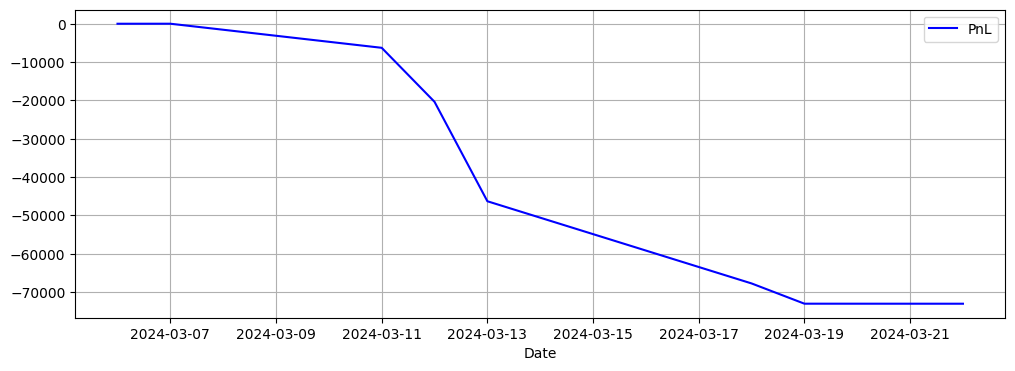

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rc

df.index.names = ["Date"]
df.rename(columns={"누적실현손익": "PnL"}, inplace=True)

ax = df[["PnL"]].plot(figsize=(12, 4), style=["b-"])

plt.grid(True)
plt.show()